## Goal:
## This notebook will work on defining states through
- TypedDict
- Dataclasses
- Pydantic

**Best Practice**
- Use `Pydantic` if you want stronger validation and to leverage LangGraph's reducer-based accumulation semantics, but expect to do some serialization handling with LangChain's message types. E.g. `messages: Annotated[List[AnyMessage], add] = Field(default_factory=list)`

- Use `Dataclass` if you want simplicity and avoid serialization quirks and validation overhead, with direct Python list appends for messages.E.g. `messages: List[AnyMessage] = field(default_factory=list)`

In [1]:
from dotenv import load_dotenv

from typing import TypedDict, Annotated, Any
from dataclasses import dataclass
from pydantic import BaseModel, ValidationError, Field
from dataclasses import dataclass, field

from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from IPython.display import display, Image

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

## TypedDict

In [4]:
class ChatState(TypedDict):
    messages: Annotated[list[AIMessage | HumanMessage], add_messages]

In [5]:
def llm_node(state: ChatState):
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

In [6]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

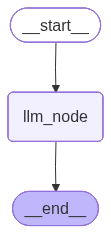

In [7]:
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
state: ChatState = {"messages": []}

In [ ]:
while True:
    user_input = input("You: ")
    if user_input == "Exit":
        break
    state["messages"].append(HumanMessage(content=user_input))
    state = app.invoke(state)
    print("Bot:", state["messages"][-1].content)    

## Pydantic
- This looks correct on the surface, but the `AttributeError` arises because `AIMessage` and `HumanMessage` are not `Pydantic models` or plain `dicts` —Pydantic tries to validate them and calls .get internally, which these classes do not implement.

In [9]:
class ChatState(BaseModel):
    messages: list[dict[str, Any]] = Field(default_factory=list)

In [10]:
def serialize_message(msg):
    if isinstance(msg, HumanMessage):
        return {"type": "human", "content": msg.content}
    elif isinstance(msg, AIMessage):
        return {"type": "ai", "content": msg.content}
    else:
        raise ValueError("Unknown message type")

def deserialize_message(msg_dict):
    if msg_dict["type"] == "human":
        return HumanMessage(content=msg_dict["content"])
    elif msg_dict["type"] == "ai":
        return AIMessage(content=msg_dict["content"])
    else:
        raise ValueError("Unknown message dict type")

In [11]:
def llm_node(state: ChatState):
    history = [deserialize_message(msg) for msg in state.messages]
    response = llm.invoke(history)
    return ChatState(messages=state.messages + [serialize_message(response)])

In [12]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

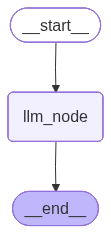

In [13]:
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
state = ChatState(messages=[])

In [15]:
while True:
    user_input = input("You: ").strip()
    if user_input.lower() == "exit":
        break
        
    # Add user's message as dict to history
    state.messages.append(serialize_message(HumanMessage(content=user_input)))
    
    # Process and update state using the graph
    raw_state = app.invoke(state)   # This returns dict
    
    # Re-create model from dict
    state = ChatState(**raw_state)  # Now state is a model with .messages
    
    # Output new AI response (deserialize first)
    print("Bot:", deserialize_message(state.messages[-1]).content)

Bot: <think>
Okay, the user sent a message with just "Okay" and then my response. Let me figure out what they need. Since they didn't ask a specific question, maybe they want me to continue the conversation or provide some information. I should ask them how I can assist. Keep it friendly and open-ended. Let me make sure my response is welcoming and encourages them to ask for help.
</think>

Hello! It looks like you might be testing the waters or just starting a conversation. How can I assist you today? Whether you have questions, need help with a project, or just want to chat, I'm here for you! 😊
Bot: <think>
Okay, the user sent a message with just an emoji. Hmm, I need to figure out the best way to respond. Maybe they're testing the system or just being playful. I should acknowledge their message and invite them to ask a question or share what they need help with. Keep the tone friendly and open-ended to encourage them to elaborate. Let me make sure my response is welcoming and not to

KeyboardInterrupt: 

## Dataclass

In [16]:
@dataclass
class ChatState:
    messages: list[AIMessage | HumanMessage] = field(default_factory=list)

In [17]:
def llm_node(state: ChatState):
    response = llm.invoke(state.messages)
    #return {"messages": state.messages + [response]}
    return ChatState(messages=state.messages + [response])

In [18]:
graph = StateGraph(ChatState)
graph.add_node("llm_node", llm_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
app = graph.compile()

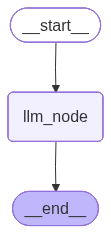

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
state = ChatState(messages=[])

In [22]:
while True:
    user_input = input("You: ").strip()
    if user_input.lower() == "exit":
        break
    state.messages.append(HumanMessage(content=user_input))
    raw_state = app.invoke(state) 
    state = ChatState(**raw_state)
    print("Bot:", state.messages[-1].content) 

Bot: <think>
Okay, so I need to figure out how sailors navigated before GPS. Let me start by recalling what I know. I remember something about stars and the sun being used. Maybe they used the North Star? Also, I think there were instruments like the astrolabe or sextant. Wait, but how exactly did those work? 

First, maybe they used the position of celestial bodies. Like, during the day, the sun's position could tell them direction, and at night, stars. The North Star, or Polaris, is always in the north, right? So if they could find that, they knew their latitude. But how did they measure that? Maybe with an astrolabe or a quadrant. 

Then there's the compass. I think the magnetic compass was used, pointing north. But the compass alone can't give exact position, just direction. So they must have combined it with celestial navigation. 

What about dead reckoning? I think that's when they estimate their position based on previous known positions, speed, and direction. But that can get i

## Useful Tips